# This the task for GEN-AI from Vincent's Granvilles book "Synthetic Data and Generative AI"

The first thing is to import the packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
import csv





Reading the data from Github from the Vincent Granville's [repo](https://github.com/VincentGranville/Main) 

The link for the project book is [here](https://github.com/VincentGranville/Large-Language-Models/blob/main/Projects4.pdf)

In [2]:
# Selecting the needed data frames according to the project book. 
insurance = 'insurance.csv'
insurance_compare = 'insurance_compare.csv'
insurance_compare_holdout = 'insurance_compare_holdout.csv'
insurance_compare_train = 'insurance_compare_train.csv'
insurance_compare_test = 'insurance_compare_test.csv'


# Getting the URL
url = "https://raw.githubusercontent.com/VincentGranville/Main/main/"
url2 = "https://raw.githubusercontent.com/jsaraviadrago/genai_synthethic/main/"

# Separating the raw data frames
raw_insurance =  url + insurance 
raw_insurance_compare = url + insurance_compare 
raw_insurance_compare_update = url2 + insurance_compare
raw_insurance_compare_holdout = url + insurance_compare_holdout
raw_insurance_compare_train = url2 + insurance_compare_train
raw_insurance_compare_test = url2 + insurance_compare_test

# Opening the links with pandas.
df_insurance = pd.read_csv(raw_insurance) #step 1
df_insurance_compare = pd.read_csv(raw_insurance_compare) # step 2
df_insurance_compare_update = pd.read_csv(raw_insurance_compare_update) #step 3 to add the generated data
df_insurance_compare_holdout = pd.read_csv(raw_insurance_compare_holdout) #step 3 to understand what should be the result
df_insurance_compare_train = pd.read_csv(raw_insurance_compare_train) # step 3 get the training set from the repo
df_insurance_compare_test = pd.read_csv(raw_insurance_compare_test) # step 3 get the training set from the repo



### Step 1: Making the histograms for the numerical variables 

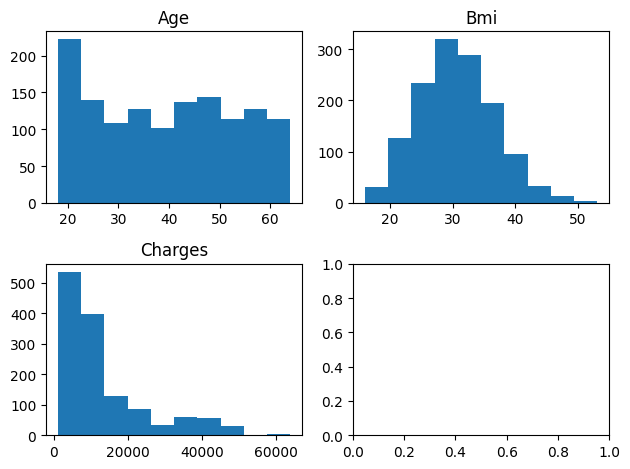

In [3]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(df_insurance['age'])
axs[0, 0].set_title("Age")
axs[1, 0].hist(df_insurance['charges'])
axs[1, 0].set_title("Charges")
axs[0, 1].hist(df_insurance['bmi'])
axs[0, 1].set_title("Bmi")
fig.tight_layout()




## Step 2: perform evaluations of vendor comparisons

Preparing the data to make some analysis. 
- Drop columns
- Erase NA values

In [4]:
# Watch out with this code, since I am overwriting the dataset you need to run first the second cell or an error will be thrown. This can be fixed if you use a script. 

df_insurance_compare = df_insurance_compare.drop('region', axis=1) # drop columns that are not useful
df_insurance_compare = df_insurance_compare.dropna(axis='columns') # Drop na row wise. 

# Create a dataset of insurance compare with only Real category
df_insurance_compare_real = df_insurance_compare.loc[df_insurance_compare['Data'] == 'Real'] 

df_insurance_compare_real = df_insurance_compare_real.drop('Data', axis=1) # drop all the NA values from Data column
df_insurance_compare_real = df_insurance_compare_real.to_numpy() # this transforms the code into a matrix in order to run the next line of code.



## Step 2.1: run the analysis after preparing the data

What did I do here? 
- Correlation matrix
- Drop the real category from the original data frame called ```df_insurance_compare```

In [5]:
# Making a correlation matrix with coefficients
r_corr = np.corrcoef(df_insurance_compare_real.T) # Here you need to transpose the data so it makes sense

#r_corr # this code prints the correlation matrix. Note if I use print it also works the only differences is that it outputs in pure python form

ltests = df_insurance_compare.Data.unique().tolist() # Here it just shows all the unique categories of the Data variable
popped_item = ltests.pop(0)   # remove real data from the tests
#print(ltests) # it just prints that the ltests object does not have the "Real" category



## Step 2.2: run the analysis to check for the data

- Calculate the distance of the correlation matrix
- Calculate the distance of the Kolmogorov-Smirnov 

In [7]:
for test in ltests:

    data_test = df_insurance_compare.loc[df_insurance_compare['Data'] == test] # select the category test
    data_test = data_test.drop('Data', axis=1) # Drop the column Data from the test_data
    data_test = data_test.to_numpy() # change the data frame into a matrix
    t_corr = np.corrcoef(data_test.T) # Run a correlation matrix
    delta = np.abs(t_corr - r_corr) # calculating the delta or difference between the correlation matrices of both test sets. The nearest to 0 the best match. 
    dim = delta.shape[0]   # number of features
  
    ks = np.zeros(dim) # Here I want to calculate the Kolmogorov-Smirnov distance remember that the lower the distance the better. Lower distance means more similarity. 
    out_of_range = 0
    for idx in range(dim): # This for loop just loops throw all the m columns 
        dr = df_insurance_compare_real[:,idx]
        dt = data_test[:,idx]
        stats = ks_2samp(dr, dt)
        ks[idx] = stats.statistic # Calculate the Kolmogorov-Smirnov distance throw all the columns
        if np.min(dt) < np.min(dr) or np.max(dt) > np.max(dr):
            out_of_range = 1
    str = "%20s %14s %8.6f %8.6f %8.6f %8.6f %1d" % (insurance_compare, test, np.mean(delta), 
              np.max(delta), np.mean(ks), np.max(ks), out_of_range)
    print(str)
    


insurance_compare.csv         YData1 0.015844 0.051774 0.020227 0.030059 0
insurance_compare.csv         YData2 0.017100 0.052157 0.022297 0.028401 0
insurance_compare.csv         Gretel 0.021085 0.092606 0.040011 0.086254 0
insurance_compare.csv            SDV 0.033703 0.350682 0.093176 0.213358 0
insurance_compare.csv  Synthesize.io 0.025702 0.070506 0.025870 0.040396 0
insurance_compare.csv      VG_Copula 0.013471 0.049100 0.016442 0.032885 0
insurance_compare.csv      Mostly.ai 0.017264 0.057882 0.023169 0.041854 0


### Step 2.3: create the scatterplot

Creating a function for the scatterplot



In [ ]:
def vg_scatter(df_insurance_compare, test, counter):

    # customized plots, insurance data 
    # one of 6 plots, subplot position based on counter

    data_plot = df_insurance_compare.loc[df_insurance_compare['Data'] == test]
    x = data_plot[['age']].to_numpy()
    y = data_plot[['charges']].to_numpy()
    plt.subplot(2, 3, counter)
    plt.scatter(x, y, s = 0.1, c ="blue")
    plt.xlabel(test, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(0,70000)
    plt.xlim(18,64)
    return()

# Set the linewidth for axes
mpl.rcParams['axes.linewidth'] = 0.3

# Plot each scatter plot
vg_scatter(df_insurance_compare, 'Real', 1)
vg_scatter(df_insurance_compare, 'YData1', 2)
vg_scatter(df_insurance_compare, 'Gretel', 3)
vg_scatter(df_insurance_compare, 'Mostly.ai', 4)
vg_scatter(df_insurance_compare, 'Synthesize.io', 5)
vg_scatter(df_insurance_compare, 'SDV', 6)

plt.tight_layout() # Just to fit it in a nice size. 
plt.show()



### Step 2.4: Create the histogram

Creating a function for the histogram and plotting the histogram




In [ ]:
def vg_histo(df, test, counter):

    # customized plots, insurance data 
    # one of 6 plots, subplot position based on counter

    data_plot = df_insurance_compare.loc[df['Data'] == test]
    y = data_plot[['charges']].to_numpy()
    plt.subplot(2, 3, counter)
    binBoundaries = np.linspace(0, 70000, 30)
    plt.hist(y, bins=binBoundaries, color='white', align='mid',edgecolor='red',
              linewidth = 0.3) 
    plt.xlabel(test, fontsize = 7)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(0,70000)
    plt.ylim(0, 250)
    return()

# Set the linewidth for axes
mpl.rcParams['axes.linewidth'] = 0.3

vg_histo(df_insurance_compare, 'Real', 1)
vg_histo(df_insurance_compare, 'YData1', 2)
vg_histo(df_insurance_compare, 'Gretel', 3)
vg_histo(df_insurance_compare, 'Mostly.ai', 4)
vg_histo(df_insurance_compare, 'Synthesize.io', 5)
vg_histo(df_insurance_compare, 'SDV', 6)

plt.tight_layout() # Just to fit it in a nice size. 
plt.show()

## Step 3: Produce a file similar to insurance compare holdout.csv but for a vendor other than YData.ai

The holdout data has 50% of the rows of validate, train and Ydata. There is also 669 Ydata2 which is the synthethic data. So, in order to start working with the insurance_compare data you need to first use the first half of the real category as explained in the book. 

**Note:** Probably in other methods you could hold data randomly. 


In [ ]:
df_insurance_compare_holdout.info() # inspecting the whole data frame

# Inspecting the data there 4 categories and Ydata1 has been used to create 669 new rows named Ydata2
df_insurance_compare_holdout['Data'].value_counts() # counting categories of data



## Step 3.1: this was done in the script. Script_insurance_synthethic_data.py

In [27]:
# Calling the output data from that script.

synthetic_data = 'insurance_synth.txt'

raw_data_synthetic = url2+synthetic_data
data = pd.read_csv(raw_data_synthetic, sep="\t", header=None)
data.columns = ["sex", "smoker", "region", "age", "bmi", "children", "charges"]
data['Data'] = "Synthetic"
data = data[['Data', 'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]

# This data in CSV is the first generated data called synthethic_data.csv




In [ ]:
# Making the data similar to the synthethic_data.csv

#df_insurance_compare_test = df_insurance_compare_test.drop(['Unnamed: 0','Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],axis=1)



### Now check the quality of the synthethization using the correlation distance matrix and KM distance

- First we bind both datasets. 

In [29]:
# Now check the quality of the synthethization using the correlation distance matrix and KM distance
synthethic_data_csv = 'synthetic_data.csv' # Calling the synthethise data. 

data_synthethic_VF = pd.read_csv(url2+synthethic_data_csv) # Reading the data

data_synthethic_VF = data_synthethic_VF[:-1] # Dropping the last row so both datasets have the same amount of lines

# Row binding the data. 
data_synthethic_test_VF = pd.concat([data_synthethic_VF, df_insurance_compare_test], ignore_index=True, axis=0)


### Checking the quality of the data

In [ ]:
data_synthethic_test_VF = data_synthethic_test_VF.drop('region', axis=1) # drop columns that are not useful
data_synthethic_test_VF = data_synthethic_test_VF.dropna(axis='columns') # Drop na row wise. 


# Create a dataset of insurance compare with only Real category
data_synthethic_test_VF_real = data_synthethic_test_VF.loc[data_synthethic_test_VF['Data'] == 'Real'] 

data_synthethic_test_VF_real = data_synthethic_test_VF_real.drop('Data', axis=1) # drop all the NA values from Data column
data_synthethic_test_VF_real = data_synthethic_test_VF_real.to_numpy() # this transforms the code into a matrix in order to run the next line of code.

In [ ]:
# Making a correlation matrix with coefficients
r_corr = np.corrcoef(data_synthethic_test_VF_real.T) # Here you need to transpose the data so it makes sense

#r_corr # this code prints the correlation matrix. Note if I use print it also works the only differences is that it outputs in pure python form

ltests = df_insurance_compare.Data.unique().tolist() # Here it just shows all the unique categories of the Data variable
popped_item = ltests.pop(0)   # remove real data from the tests
#print(ltests) # it just prints that the ltests object does not have the "Real" category


## Open the synthetics data created from the other synthethic data

In [32]:
synthetic_synthetic_data = 'insurance_synth_synth.txt'

raw_data_synthetic_synthetic = url2+synthetic_synthetic_data
data_2synthethic = pd.read_csv(raw_data_synthetic_synthetic, sep="\t", header=None)
data_2synthethic.columns = ["sex", "smoker", "region", "age", "bmi", "children", "charges"]
data_2synthethic['Data'] = "Synthetic"
data_2synthethic = data_2synthethic[['Data', 'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']]

# Now this is a .csv file called synthethic_synthethic_data.csv


### Joining the data of both synthethic


In [ ]:
synthetic_synthetic_data_VF = 'synthetic_synthetic_data.csv'

raw_data_synthetic_synthetic_VF = url2+synthetic_synthetic_data_VF
data_2synthethic_VF = pd.read_csv(raw_data_synthetic_synthetic_VF)

data_2synthethic_VF = data_2synthethic_VF[:-1]

data_3synthethic_VF = pd.concat([data_synthethic_VF,data_2synthethic_VF],ignore_index=True, axis=0)



### Now check the synthethization and its performance